## QPPQ Ensemble Generation

Here we consider an ensemble of generated the historic reconstruction timeseries using a probabalistic variation of the QPPQ method.  

In [1]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import sys
import datetime as dt
import seaborn as sns
import h5py

# Import the QPPQ model
from QPPQModel import StreamflowGenerator

from utils.data_processing import export_dict_ensemble_to_hdf5, extract_realization_from_hdf5
from utils.inflow_scaling_regression import train_inflow_scale_regression_models, predict_inflow_scaling
from utils.inflow_scaling_regression import get_quarter

# Directory to pywrdrb project
pywrdrb_directory = '../Pywr-DRB/'
sys.path.append(pywrdrb_directory)

from pywrdrb.pywr_drb_node_data import obs_pub_site_matches


In [2]:
# Model generation specifications
full_date_range = ('1945-01-01', '2022-12-31')
max_daterange = pd.date_range('1945-01-01', '2022-12-31')
N_REALIZATIONS = 5
K = 5
donor_fdc = 'nhmv10'
hru_scaled = False
remove_mainstem_gauges = True
regression_nhm_inflow_scaling = True

# Constants
cms_to_mgd = 22.82
fdc_quantiles = [0.0003, 0.005, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.93, 0.95, 0.97, 0.995, 0.9997]

### Load data 
Q = pd.read_csv(f'./data/historic_unmanaged_streamflow_1900_2023_cms.csv', sep = ',', index_col = 0, parse_dates=True)*cms_to_mgd
nhm_flow = pd.read_csv(f'{pywrdrb_directory}/input_data/gage_flow_nhmv10.csv', sep =',',  index_col = 0, parse_dates=True)
nwm_flow = pd.read_csv(f'{pywrdrb_directory}/input_data/gage_flow_nwmv21.csv', sep =',',  index_col = 0, parse_dates=True)
nyc_nhm_inflows = pd.read_csv('./data/nyc_inflow_nhm_streamflow.csv', sep = ',', index_col = 0, parse_dates=True)


prediction_locations = pd.read_csv(f'./data/prediction_locations.csv', sep = ',', index_col=0)
gauge_meta = pd.read_csv(f'./data/drb_unmanaged_usgs_metadata.csv', sep = ',', dtype = {'site_no':str})
gauge_meta.set_index('site_no', inplace=True)

# Some gauge data is faulty
gauge_meta.loc['01414000', 'begin_date'] = '1996-12-05'
gauge_meta.loc['0142400103', 'begin_date'] = '1996-12-05'

# Get estiamtes of FDCs at all nodes; to be used for QPPQ when no data is available
node_fdcs = pd.DataFrame(index = prediction_locations.index, columns=fdc_quantiles)
if donor_fdc == 'nhmv10':
    fdc_donor_flow = nhm_flow
elif donor_fdc == 'nwmv21':
    fdc_donor_flow = nwm_flow
else:
    print('Invalid donor_fdc specification. Options: nhmv10, nwmv21')

for i, node in enumerate(prediction_locations.index):
    node_fdcs.loc[node, :] = np.quantile(fdc_donor_flow.loc[:,node], fdc_quantiles)
    
# Remove outflow gauges from flow data
for node, sites in obs_pub_site_matches.items():
    if f'USGS-{node}' in Q.columns:
        print(f'Removing {node} from data.')
        Q = Q.drop(f'USGS-{node}', axis=1)

# Remove Trenton mainstem gauge
if remove_mainstem_gauges:
    if f'USGS-{obs_pub_site_matches["delTrenton"]}' in Q.columns:
        print(f'Removing Trenton gauge from data.')
        Q = Q.drop(f'USGS-{obs_pub_site_matches["delTrenton"]}', axis=1)
    if f'USGS-{obs_pub_site_matches["delMontague"]}' in Q.columns:
        print(f'Removing Montague gauge from data.')
        Q = Q.drop(f'USGS-{obs_pub_site_matches["delMontague"]}', axis=1)

    obs_pub_site_matches['delTrenton'] = None
    obs_pub_site_matches['delDRCanal'] = None
    obs_pub_site_matches['delMontague'] = None

# Make sure other inflow gauges are in the dataset
missing = 0
for node, sites in obs_pub_site_matches.items():
    if sites is not None:
        for s in sites:
            if f'USGS-{s}' not in Q.columns:
                print(f'Site {s} for node {node} is not available')
#assert(missing == 0), 'Atleast one of the inflow gauge timeseries if not available in the data.'


In [3]:
# Set-up QPPQ
reconstructed_sites = []
for node, sites in obs_pub_site_matches.items():
    if node == 'delDRCanal':
        pass
    elif sites is None:
        reconstructed_sites.append(node)
    else:
        for s in sites:
            reconstructed_sites.append(s)

# Intialize storage
max_annual_NA_fill = 20
Q_reconstructed = pd.DataFrame(index=max_daterange, columns = reconstructed_sites)
ensemble_Q_reconstructed = {}

N_YEARS = int(np.floor(len(max_daterange)/365))

starts = [f'{1945+i}-01-01' for i in range(N_YEARS)]
ends = [f'{1945+i}-12-31' for i in range(N_YEARS)]
daterange_subsets = np.vstack([starts, ends]).transpose()
assert(pd.to_datetime(daterange_subsets[-1,-1]).date() <= Q.index.max().date()), 'The historic data must be more recent than QPPQ daterange.'

In [4]:
nyc_nhm_inflows

,cannonsville_gages,cannonsville_hru,pepacton_gages,pepacton_hru
1980-10-01,205.260038,130.379373,155.076631,89.325193
1980-10-02,301.328504,320.876434,185.838273,234.425929
1980-10-03,337.724806,384.188487,189.273447,261.300230
1980-10-04,278.028778,345.220715,191.637549,265.843778
1980-10-05,272.786389,322.869093,173.700640,257.040294
...,...,...,...,...
2016-12-27,637.067623,719.725849,389.488972,565.227079
2016-12-28,666.170442,790.547805,382.805360,580.058363
2016-12-29,609.701879,755.997465,349.558361,557.718339
2016-12-30,561.925610,694.034674,326.031311,515.387778


In [5]:
nyc_inflows = nyc_nhm_inflows
reservoir = 'cannonsville'
nyc_inflows.loc[:, [f'{reservoir} scaling']] = nyc_inflows[f'{reservoir}_hru'] / nyc_inflows[f'{reservoir}_gages']
nyc_inflows

,cannonsville_gages,cannonsville_hru,pepacton_gages,pepacton_hru,cannonsville scaling
1980-10-01,205.260038,130.379373,155.076631,89.325193,0.635191
1980-10-02,301.328504,320.876434,185.838273,234.425929,1.064872
1980-10-03,337.724806,384.188487,189.273447,261.300230,1.137579
1980-10-04,278.028778,345.220715,191.637549,265.843778,1.241673
1980-10-05,272.786389,322.869093,173.700640,257.040294,1.183597
...,...,...,...,...,...
2016-12-27,637.067623,719.725849,389.488972,565.227079,1.129748
2016-12-28,666.170442,790.547805,382.805360,580.058363,1.186705
2016-12-29,609.701879,755.997465,349.558361,557.718339,1.239946
2016-12-30,561.925610,694.034674,326.031311,515.387778,1.235101


In [124]:
import statsmodels.api as sm

quarters = ('DJF','MAM','JJA','SON')

def get_quarter(m):
    if m in (12,1,2):
        return 'DJF'
    elif m in (3,4,5):
        return 'MAM'
    elif m in (6,7,8):
        return 'JJA'
    elif m in (9,10,11):
        return 'SON'

def train_inflow_scale_regression_models(reservoir, nyc_inflows):
    
    nyc_inflows = nyc_inflows['1983-10-01':]
    nyc_inflows.loc[:,['month']] = nyc_inflows.index.month.values
    nyc_inflows.loc[:, ['quarter']] = [get_quarter(m) for m in nyc_inflows['month']]
    nyc_inflows.loc[:, [f'{reservoir} scaling']] = nyc_inflows[f'{reservoir}_hru'] / nyc_inflows[f'{reservoir}_gages']
    
    lrms = {q: sm.OLS(nyc_inflows[f'{reservoir} scaling'].loc[nyc_inflows['quarter'] == q].values.flatten(),
                    sm.add_constant(np.log(nyc_inflows[f'{reservoir}_gages'].loc[nyc_inflows['quarter'] == q].values.flatten()))) for q in quarters}

    lrrs = {q: lrms[q].fit() for q in quarters}
    return lrms, lrrs


def predict_inflow_scaling(lrm, lrr, log_flow, method = 'regression'):

    X = sm.add_constant(log_flow)
    if method == 'sample':
        exog = lrm.exog
        exog[:,1] = log_flow
        samples = lrm.get_distribution(lrr.params, scale = np.var(lrr.resid), exog = exog).rvs()
        scaling = samples[0]
    elif method == 'regression':
        scaling = lrr.predict(X)
        
    scaling[scaling<1] = 1
    scaling = pd.DataFrame(scaling, index = log_flow.index)
    return scaling

if regression_nhm_inflow_scaling:
    linear_models = {}
    linear_results = {}

    for reservoir in ['cannonsville', 'pepacton']:
        linear_models[reservoir], linear_results[reservoir] = train_inflow_scale_regression_models(reservoir, 
                                                                                                   nyc_nhm_inflows)
Q.index = pd.to_datetime(Q.index.date)
test_Q = Q.loc['2012-01-01':'2014-01-01', ['USGS-01411456', 'USGS-01413500']]
test_Q['total'] = test_Q.sum(axis=1)
scaled_Q = test_Q.copy()

for m in range(1,13):
    print(m)
    scale = predict_inflow_scaling(linear_models['cannonsville']['MAM'],
                        linear_results['cannonsville']['MAM'],
                        np.log(test_Q.loc[test_Q.index.month == m].sum(axis=1)))

    scale['USGS-01411456'] = scale.iloc[:,0]
    scale['USGS-01413500']= scale.iloc[:,0]

    scaled_Q.loc[scaled_Q.index.month == m, 'USGS-01411456'] = scaled_Q.loc[scaled_Q.index.month == m, 'USGS-01411456'] * scale['USGS-01411456']


1
2
3
4
5
6
7
8
9
10
11
12


In [127]:
scaled_Q.tail()

np.log(test_Q.loc[test_Q.index.month == m].sum(axis=1))
# test_Q.tail()
# scaled_Q.loc[scaled_Q.index.month == m, 'USGS-01411456'] 

AttributeError: 'float' object has no attribute 'log'

In [122]:
scaled_Q.loc[test_Q.index.month == 12, 'USGS-01411456'] = test_Q.loc[test_Q.index.month == 12, 'USGS-01411456'] * scale['USGS-01411456']

In [138]:
np.log(test_Q.loc[test_Q.index.month == 12,  ['USGS-01411456', 'USGS-01413500']].sum(axis=1))

2012-12-01    4.494570
2012-12-02    4.519870
2012-12-03    4.643998
2012-12-04    4.551456
2012-12-05    4.610049
                ...   
2013-12-27    6.031193
2013-12-28    5.878860
2013-12-29    6.074044
2013-12-30    6.350169
2013-12-31    5.927745
Length: 62, dtype: float64

In [36]:
import statsmodels.api as sm

def predict_inflow_scaling(lrm, lrr, log_flow, method = 'regression'):
    exog = lrm.exog
    exog[:,1] = log_flow
    # X = sm.add_constant(log_flow)
    if method == 'sample':
        samples = lrm.get_distribution(lrr.params, scale = np.var(lrr.resid), exog = exog).rvs()
        scaling = samples[0]
    elif method == 'regression':
        scaling = lrm.predict(exog)
        
    # if scaling < 1.0:
    #     scaling = 1.0
    return scaling

ValueError: shapes (3036,2) and (3036,2) not aligned: 2 (dim 1) != 3036 (dim 0)

In [39]:
## QPPQ prediction
# Generate 1 year at a time, to maximize the amount of data available for each years QPPQ
for real in range(N_REALIZATIONS):
    print(f'Generation realization {real} of {N_REALIZATIONS}.')
    for i, dates in enumerate(daterange_subsets):
        # Run predictions one location at a time
        for node, sites in obs_pub_site_matches.items():
            
            # Pull gauges that have flow during daterange
            Q_subset = Q.loc[dates[0]:dates[1], :].dropna(axis=1)
            subset_sites = [f'{i.split("-")[1]}' for i in Q_subset.columns]
            gauge_meta_subset = gauge_meta.loc[subset_sites, :]
            gauge_meta_subset.index = Q_subset.columns
            
            # Initialize the model
            model = StreamflowGenerator(K= K,
                                        observed_flow = Q_subset, 
                                        observation_locations=gauge_meta_subset,
                                        probabalistic_sample = True)

            # Handle sites with historic data
            if sites is not None:
                for s in sites:
                    # First, use observation data if available
                    number_of_nas = Q.loc[dates[0]:dates[1], f'USGS-{s}'].isna().sum()
                    if (number_of_nas == 0):
                        Q_reconstructed.loc[dates[0]:dates[1], s] = Q.loc[dates[0]:dates[1], f'USGS-{s}'].values
                    elif (number_of_nas <= max_annual_NA_fill):
                        # print(f'Filling {number_of_nas} NAs for site {s} using median.')
                        Q_reconstructed.loc[dates[0]:dates[1], s] = Q.loc[dates[0]:dates[1], f'USGS-{s}'].values
                        
                        # Fill NA using median                    
                        na_indices = Q.loc[dates[0]:dates[1],:].loc[Q.loc[dates[0]:dates[1], f'USGS-{s}'].isna(), :].index
                        median_flow = np.median(Q.loc[dates[0]:dates[1], :].loc[~Q.loc[dates[0]:dates[1], f'USGS-{s}'].isna(), f'USGS-{s}'])
                        Q_reconstructed.loc[na_indices.date, s] = median_flow
                            
                    # If flow data isn't available, use historic observation to generate FDC and make PUB predictions
                    else:
                        # print(f'Using partial record for {s} during {dates}')
                        location = gauge_meta.loc[s, ['long', 'lat']].values
                        incomplete_site_flows = Q.loc[:, f'USGS-{s}'].dropna(axis=0)
                        
                        # Only use site flows for FDC if longer than 10-year record
                        if len(incomplete_site_flows)/365 >= 10:
                            fdc = np.quantile(incomplete_site_flows.values, fdc_quantiles)
                        else:
                            fdc = node_fdcs.loc[node, :].astype('float').values            
            
                        Q_reconstructed.loc[dates[0]:dates[1], s] = model.predict_streamflow(location, fdc).values.flatten()
            else:
                # print(f'Full PUB for {s} during {dates}')
                location = prediction_locations.loc[node, ['long', 'lat']].values
                fdc = node_fdcs.loc[node, :].astype('float').values

                Q_reconstructed.loc[dates[0]:dates[1], node] = model.predict_streamflow(location, fdc).values.flatten()
                
            # Apply NHM scaling at Cannonsville and Pepacton
            if (node in ['cannonsville', 'pepacton']) and regression_nhm_inflow_scaling:
                unscaled_inflows = Q_reconstructed.loc[dates[0]:dates[1], obs_pub_site_matches[node]].sum(axis=1).values
                scaling_coef = np.zeros_like(unscaled_inflows)
                
                # Use linear regression to find inflow scaling coefficient
                for i, day_month in enumerate(Q_reconstructed.loc[dates[0]:dates[1], :].index.month):
                    quarter = get_quarter(day_month)
                    
                    scaling_coef[i] = predict_inflow_scaling(linear_models[node][quarter], 
                                               linear_results[node][quarter], 
                                                log_flow= np.log(unscaled_inflows[i]),
                                                method='mean')
                                        
                # Apply daily scaling equally across gauges
                for site in obs_pub_site_matches[node]:
                    Q_reconstructed.loc[dates[0]:dates[1], site] = np.multiply(Q_reconstructed.loc[dates[0]:dates[1], site].values,
                                                                               scaling_coef)
                    
    assert(Q_reconstructed.isna().sum().sum() == 0), ' There are NAs in the reconstruction'
    
    ensemble_Q_reconstructed[f'realization_{real}'] = Q_reconstructed.copy()


Generation realization 0 of 5.


UnboundLocalError: local variable 'scaling' referenced before assignment

In [1]:
def export_dict_ensemble_to_hdf5(dict, output_file):
    N = len(dict)
    T, M = dict[f'realization_0'].shape
    column_labels = dict[f'realization_0'].columns.to_list()
    
    with h5py.File(output_file, 'w') as f:
        for i in range(N):
            data = dict[f'realization_{i}']
            datetime = data.index.astype(str).tolist() #.strftime('%Y-%m-%d').tolist()
            
            grp = f.create_group(f"realization_{i+1}")
                    
            # Store column labels as an attribute
            grp.attrs['column_labels'] = column_labels

            # Create dataset for dates
            grp.create_dataset('date', data=datetime)
            
            # Create datasets for each location's timeseries
            for j in range(M):
                dataset = grp.create_dataset(column_labels[j], data=data[column_labels[j]].to_list())



def extract_realization_from_hdf5(hdf5_file, realization):
    with h5py.File(hdf5_file, 'r') as f:
        realization_group = f[f"realization_{realization}"]
        
        # Extract column labels
        column_labels = realization_group.attrs['column_labels']
        
        # Extract timeseries data for each location
        data = {}
        for label in column_labels:
            dataset = realization_group[label]
            data[label] = dataset[:]
        
        # Get date indices
        dates = realization_group['date'][:].tolist()
        # dates = pd.to_datetime([d[1:] for d in dates])
        
    # Combine into dataframe
    df = pd.DataFrame(data, index = dates)
    df.index = pd.to_datetime(df.index.astype(str))
    return df

export_dict_ensemble_to_hdf5(ensemble_Q_reconstructed, f'./outputs/ensembles/historic_reconstruction_daily_ensemble_{N_REALIZATIONS}.hdf5')

df = extract_realization_from_hdf5(f'./outputs/ensembles/historic_reconstruction_daily_ensemble_{N_REALIZATIONS}.hdf5', 1)
df.tail()

NameError: name 'ensemble_Q_reconstructed' is not defined

## Visualize ensemble

A quick check on the range of flows observed.

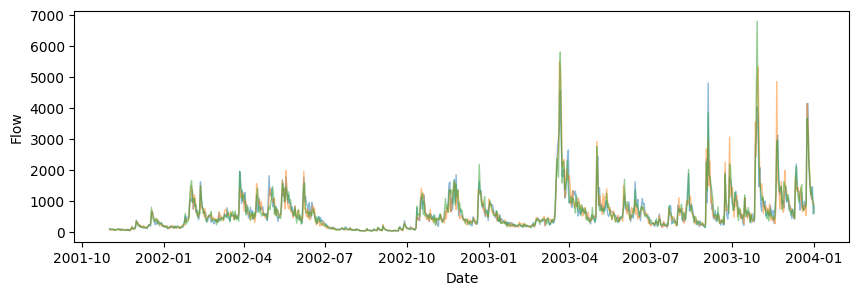

In [72]:
node = 'pepacton'
inflow_gauges = obs_pub_site_matches[node]
start_date = '2001-11-01'
end_date = '2004-01-01'

fig, ax = plt.subplots(figsize = (10,3))

for real in range(N_REALIZATIONS):
    if inflow_gauges:
        Q = ensemble_Q_reconstructed[f'realization_{real}'].loc[:,inflow_gauges].sum(axis=1)
    else:
        Q = ensemble_Q_reconstructed[f'realization_{real}'].loc[:,node]
    Q = Q.loc[start_date:end_date]
    # month_mins = Q.groupby(Q.index.month).min()
    # month_max = Q.groupby(Q.index.month).max()
    # ax.plot(month_max.index, month_max, label = f'R{real}')
    # ax.plot(month_mins.index, month_mins, label = f'R{real}')
    ax.plot(Q.index, Q, alpha = 0.5, linewidth=1)
    # ax.plot(fdc_quantiles, np.quantile(Q.values, fdc_quantiles))


# plt.yscale('log')

plt.ylabel('Flow')
# plt.legend()
plt.xlabel('Date')
plt.show()    
